In [85]:
#Prediction task is to determine whether a person makes over 50K a year, Which factors are important, Which algorithms are best for this dataset

#Import the required libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#Import the dataset
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, low_memory=False)

test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1,header=None,low_memory=False)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [86]:
#Check the datatype for each column
train_set.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
wage_class        object
dtype: object

In [72]:
#Convert factors to labels
le = LabelEncoder()
train_set['workclass'] = le.fit_transform(train_set['workclass'])
train_set['education'] = le.fit_transform(train_set['education'])
train_set['marital_status'] = le.fit_transform(train_set['marital_status'])
train_set['occupation'] = le.fit_transform(train_set['occupation'])
train_set['relationship'] = le.fit_transform(train_set['relationship'])
train_set['race'] = le.fit_transform(train_set['race'])
train_set['sex'] = le.fit_transform(train_set['sex'])
train_set['native_country'] = le.fit_transform(train_set['native_country'])
train_set['wage_class'] = le.fit_transform(train_set['wage_class'])
test_set['workclass'] = le.fit_transform(test_set['workclass'])
test_set['education'] = le.fit_transform(test_set['education'])
test_set['marital_status'] = le.fit_transform(test_set['marital_status'])
test_set['occupation'] = le.fit_transform(test_set['occupation'])
test_set['relationship'] = le.fit_transform(test_set['relationship'])
test_set['race'] = le.fit_transform(test_set['race'])
test_set['sex'] = le.fit_transform(test_set['sex'])
test_set['native_country'] = le.fit_transform(test_set['native_country'])
test_set['wage_class'] = le.fit_transform(test_set['wage_class'])

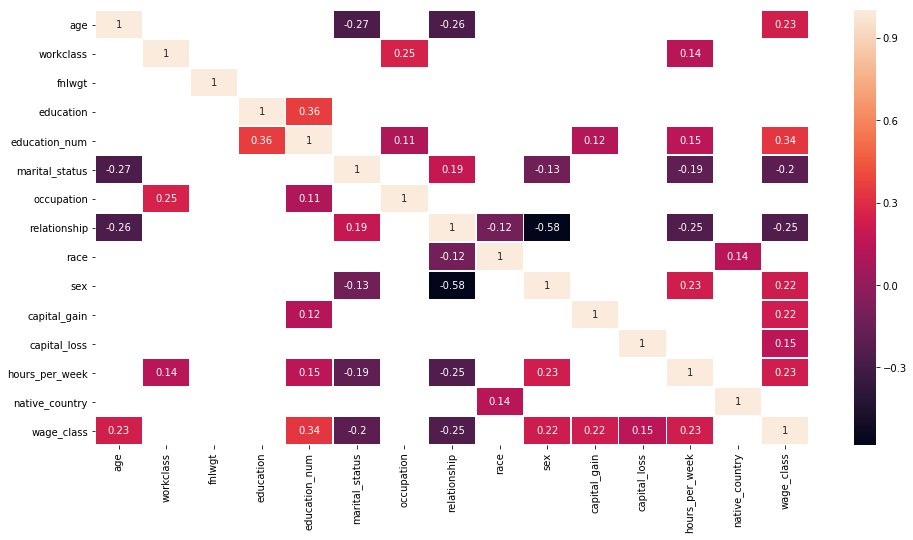

In [73]:
#Check for correlation between variables
plt.subplots(figsize=(16,8))
sns.heatmap(train_set.corr()[train_set.corr().abs()>0.1],annot=True, linewidth=.5)

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


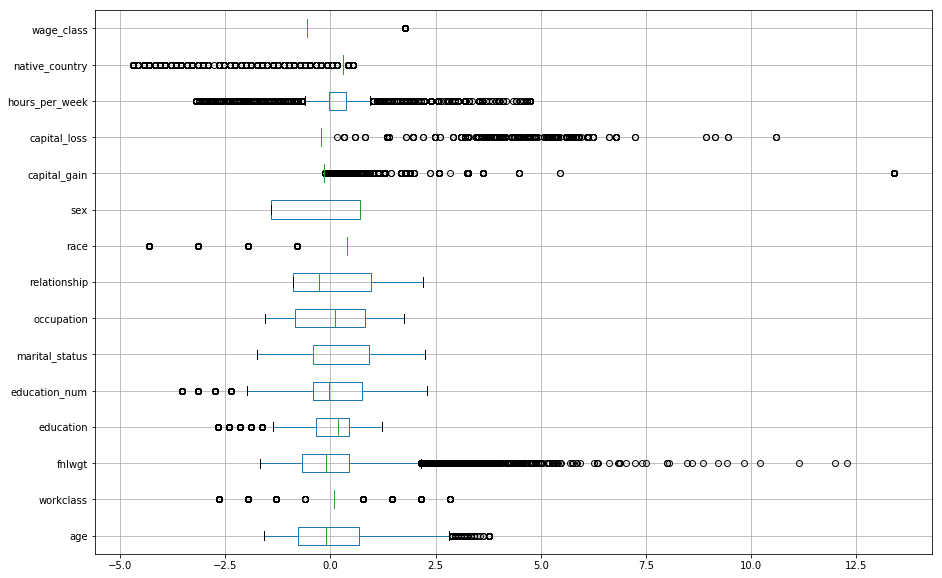

In [74]:
#Outlier check

scaler = StandardScaler().fit(train_set)
y = pd.DataFrame(scaler.transform(train_set),columns=train_set.columns)
y.boxplot(vert=False,figsize=(15,10))

In [76]:
#Perform outlier treatment for non-categorical columns
column_list = ('hours_per_week', 'capital_loss', 'capital_gain', 'fnlwgt', 'age')
for col in column_list:
    q1 = train_set[col].quantile(0.25)
    q3 = train_set[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    percentiles = train_set[col].quantile([0.01,0.99]).values
    #train_set[col][train_set[col] <= low] = percentiles[0]
    #train_set[col][train_set[col] >= high] = percentiles[1]
    train_set[col][train_set[col] <= percentiles[0]] = percentiles[0]
    train_set[col][train_set[col] >= percentiles[1]] = percentiles[1]
    
for col in column_list:
    q1 = test_set[col].quantile(0.25)
    q3 = test_set[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    percentiles = test_set[col].quantile([0.01,0.99]).values
    #test_set[col][test_set[col] <= low] = percentiles[0]
    #test_set[col][test_set[col] >= high] = percentiles[1]
    test_set[col][test_set[col] <= percentiles[0]] = percentiles[0]
    test_set[col][test_set[col] >= percentiles[1]] = percentiles[1]

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,wage_class
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,1
8,1
9,1


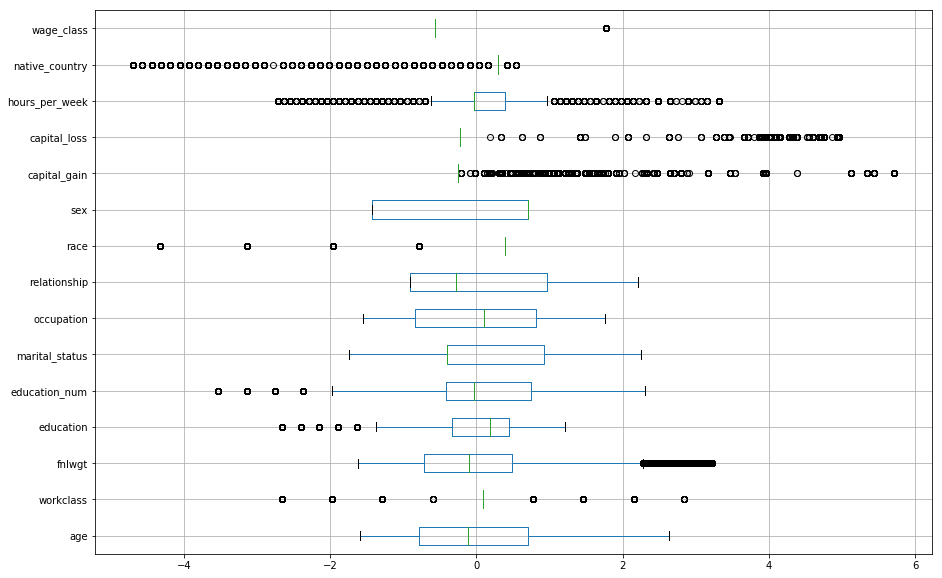

In [77]:
#Outlier check after the treatment
scaler = StandardScaler().fit(train_set)
y = pd.DataFrame(scaler.transform(train_set), columns = train_set.columns)
y.boxplot(vert=False,figsize=(15,10))

#Drop the dependent variable 'wage_class' and non-required column 'education' as 'education_num' has the same information
X_train = train_set.drop(['wage_class', 'education'],axis=1)
Y_train = train_set[['wage_class']]
X_test = test_set.drop(['wage_class', 'education'],axis=1)
Y_test = test_set[['wage_class']]
Y_train



In [80]:
#Perform standard scalar normalization to normalize the feature set
sc = StandardScaler()  
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)
X_train.head()

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.034988,2.150579,-1.113417,1.134739,0.921634,-1.317809,-0.277805,0.393668,0.703071,0.610928,-0.218828,-0.032700,0.291569
1,0.850963,1.463736,-1.055314,1.134739,-0.406212,-0.608387,-0.900181,0.393668,0.703071,-0.251406,-0.218828,-2.294188,0.291569
2,-0.039191,0.090050,0.271533,-0.420060,-1.734058,-0.135438,-0.277805,0.393668,0.703071,-0.251406,-0.218828,-0.032700,0.291569
3,1.073501,0.090050,0.462787,-1.197459,-0.406212,-0.135438,-0.900181,-1.962621,0.703071,-0.251406,-0.218828,-0.032700,0.291569
4,-0.780986,0.090050,1.502406,1.134739,-0.406212,0.810458,2.211698,-1.962621,-1.422331,-0.251406,-0.218828,-0.032700,-4.054223


In [81]:
#Check multicollinearity using variance inflation factor
x_features = list(X_train)

data_mat = X_train[x_features].as_matrix()
print(data_mat.shape)
vif = [ variance_inflation_factor( data_mat,i) for i in range(data_mat.shape[1]) ]
vif_factors = pd.DataFrame()
vif_factors['column'] = list(x_features)
vif_factors['vif'] = vif
print(vif_factors)

#None of the factors have high variance inflation factor. So no need to remove any of the factors. All the factors are independent of each other

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(32561, 13)
            column       vif
0              age  1.172021
1        workclass  1.093035
2           fnlwgt  1.012832
3    education_num  1.079659
4   marital_status  1.130772
5       occupation  1.086805
6     relationship  1.684750
7             race  1.038265
8              sex  1.561134
9     capital_gain  1.059764
10    capital_loss  1.019474
11  hours_per_week  1.146641
12  native_country  1.025596


In [82]:
#Perform PCA 
pca = PCA()  
X_train = pd.DataFrame(pca.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(pca.transform(X_test), columns = X_test.columns)
explained_variance = pca.explained_variance_ratio_ 
explained_variance

#Since each of the principal component is responsible for less than 17% variance, each of the component is important and needs to be considered while building the model

array([0.16469022, 0.0976354 , 0.09220839, 0.08659451, 0.08061595,
       0.07828014, 0.07282683, 0.06711692, 0.06496102, 0.06010807,
       0.05411751, 0.05139618, 0.02944885])

In [83]:
#Test options and evaluation metric
from xgboost import XGBClassifier
num_folds = 10
seed = 7
scoring = 'accuracy'
# Spot-Check Algorithms
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('XGBoost Classifier',XGBClassifier()))
print(models)

[('Logistic Regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('Decision Tree Classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), ('XGBoost Classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alph

In [84]:
# evaluate each model in turn
results = []
names = []
model_comp=pd.DataFrame(columns=['Model','Test Accuracy','Std.Dev'])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    model_comp=model_comp.append([{'Model':name, 'Test Accuracy':cv_results.mean(), 'Std.Dev':cv_results.std()}],ignore_index=True)
model_comp

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConve

,Model,Test Accuracy,Std.Dev
0,Logistic Regression,0.825835,0.005021
1,Decision Tree Classifier,0.791284,0.005609
2,XGBoost Classifier,0.844907,0.005517


In [ ]:
#THe XGBoost Classifier model gives the best performance in terms of accuracy - 84.49%. So XGBoost Classifer algorithm is best suied for this dataset